In [1]:
import src.test_functions as test_functions

In [2]:
import os

os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1'
os.environ['XLA_FLAGS']='--xla_gpu_force_compilation_parallelism=1'

In [3]:
import scipy
import numpy as np
from jax import numpy as jnp

In [4]:
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn
import torch

from tqdm import tqdm

In [6]:
from sympy import symbols, Max
import sympy

In [7]:
from pyibex import Interval, IntervalVector, Function, CtcFwdBwd, SepFwdBwd, GEQ

In [8]:
seed = 12

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

##  Sample points for training

In [9]:
def sample(function, bounds, n, local_minima=False):
    assert isinstance(bounds, np.ndarray)
    assert bounds.shape[1] == 2
    xs = np.random.rand(n, bounds.shape[0]) * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]
    ys = np.array([function(x).item() for x in xs])
    
    if local_minima:
        xs_local_opt = []
        ys_local_opt = []
        for x0 in xs:
            opt_res = scipy.optimize.minimize(func, x0, method='Nelder-Mead')
            if opt_res.success:
                xs_local_opt.append(opt_res.x)
                ys_local_opt.append(opt_res.fun)
        xs_local_opt, ys_local_opt = np.array(xs_local_opt), np.array(ys_local_opt)
        return xs, ys, xs_local_opt, ys_local_opt
    
    return xs, ys

In [10]:
dimension = 5

func = test_functions.Ackley(dims=dimension)
# variables, expression = func.expression()

bounds = func.get_default_domain()
lb = bounds.T[0]
ub = bounds.T[1]

In [11]:
sampled_xs, sampled_ys = sample(func, bounds, 5000, local_minima=False)

## Fit a neural network

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
xs_train = sampled_xs
ys_train = np.expand_dims(sampled_ys, axis=1)

In [14]:
hidden_dim = 16

model = nn.Sequential(
    nn.Linear(dimension, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, 1)
)

In [15]:
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [16]:
num_epochs = 10000

model.to(device)

loss_record = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    x_train_tensor = torch.FloatTensor(xs_train).to(device)
    y_train_tensor = torch.FloatTensor(ys_train).to(device)
    y_pred = model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    
    loss_record.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2117.17it/s]


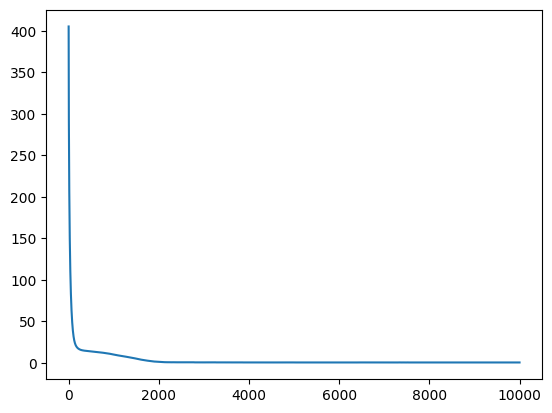

In [17]:
plt.plot(loss_record)

In [18]:
loss_record[-1]

0.32054373621940613

## Convert the neural network to dReal

In [19]:
import dreal

In [20]:
initial_variables = [dreal.Variable('x[{}]'.format(i)) for i in range(dimension)]

In [21]:
curr_vars = initial_variables
formulas_by_layer = []
vars_by_layer = [initial_variables]

for layer_idx, layer in enumerate(model):
    prev_vars = curr_vars
    if isinstance(layer, nn.Linear):
        W = layer.weight.detach().cpu().numpy()
        b = np.expand_dims(layer.bias.detach().cpu().numpy(), axis=1)
        X = np.expand_dims(prev_vars, axis=1)
        
        curr_vars = [dreal.Variable("x[{}][{}]".format(layer_idx + 1, i)) for i in range(W.shape[0])]
        vars_by_layer.append(curr_vars)
        expressions = (W @ X + b)[:, 0]
        
        formulas = [(curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)]
        formulas_by_layer.append(formulas)
        
    elif isinstance(layer, nn.ReLU):
        layer_width = len(prev_vars)
        curr_vars = [dreal.Variable("x[{}][{}]".format(layer_idx + 1, i)) for i in range(layer_width)]
        vars_by_layer.append(curr_vars)
        
        expressions = [dreal.Max(0, prev_var) for prev_var in prev_vars]
        
        formulas = [(curr_var == expr) for curr_var, expr in zip(curr_vars, expressions)]
        formulas_by_layer.append(formulas)
        

In [22]:
all_formulas_nn = [formula for formulas in formulas_by_layer for formula in formulas]

In [23]:
all_formulas_nn

[<Formula "(x[1][0] == (-1.9414960145950317 + 0.15515927970409394 * x[0] - 0.32534942030906678 * x[1] + 0.0041549927555024624 * x[2] - 0.082884244620800019 * x[3] + 0.05991709977388382 * x[4]))">,
 <Formula "(x[1][1] == (-1.9709373712539672 - 0.2819245457649231 * x[0] - 0.045565161854028702 * x[1] - 0.12817178666591645 * x[2] - 0.13183242082595826 * x[3] + 0.087556235492229462 * x[4]))">,
 <Formula "(x[1][2] == (-1.5778150558471679 - 0.31237319111824036 * x[0] + 0.24658638238906861 * x[1] + 0.082119926810264588 * x[2] + 0.13758325576782227 * x[3] - 0.089378312230110169 * x[4]))">,
 <Formula "(x[1][3] == (1.4813206195831299 - 0.122891403734684 * x[0] + 0.2678927481174469 * x[1] + 0.053974322974681855 * x[2] + 0.083829909563064576 * x[3] - 0.061911553144454957 * x[4]))">,
 <Formula "(x[1][4] == (0.27967938780784607 - 0.011653277091681958 * x[0] - 0.026970148086547852 * x[1] - 0.1773340255022049 * x[2] + 0.14389668405056 * x[3] - 0.0057845404371619225 * x[4]))">,
 <Formula "(x[1][5] == (3

In [24]:
nn_value = vars_by_layer[-1][0]

## Convert Ackley to dReal

In [25]:
input_variables = initial_variables
a = 20
b = 0.2
c = 2 * np.pi

In [26]:
ackley_constraints = []

In [27]:
# Term 1

In [28]:
squared_summation = 0
for var in input_variables:
    squared_summation += var ** 2

In [29]:
var_ss = dreal.Variable("var_squared_summation")
ackley_constraints.append(var_ss == squared_summation)

In [30]:
var_sqrt = dreal.Variable("var_sqrt")
ackley_constraints.append(var_sqrt == (1 / dimension * var_ss) ** 0.5)

In [31]:
var_exp_1 = dreal.Variable("var_exp_1")
ackley_constraints.append(var_exp_1 == dreal.exp(-b * var_sqrt))

In [32]:
term_1 = -a * var_exp_1

In [33]:
# Term 2

In [34]:
cos_summation = 0
for var in input_variables:
    cos_summation += dreal.cos(c * var)

In [35]:
var_cos_sum = dreal.Variable("var_cos_summation")
ackley_constraints.append(var_cos_sum == cos_summation)

In [36]:
var_exp_2 = dreal.Variable("var_exp_2")
ackley_constraints.append(var_exp_2 == dreal.exp((1 / dimension * var_cos_sum)))

In [37]:
term_2 = -var_exp_2

In [38]:
ackley_value = dreal.Variable("ackley_value")

In [39]:
ackley_constraints.append(ackley_value == term_1 + term_2 + a + np.exp(1))

In [40]:
ackley_constraints

[<Formula "(var_squared_summation == (pow(x[0], 2) + pow(x[1], 2) + pow(x[2], 2) + pow(x[3], 2) + pow(x[4], 2)))">,
 <Formula "(var_sqrt == pow((0.20000000000000002 * var_squared_summation), 0.5))">,
 <Formula "(var_exp_1 == exp((-0.20000000000000001 * var_sqrt)))">,
 <Formula "(var_cos_summation == (cos((6.2831853071795863 * x[0])) + cos((6.2831853071795863 * x[1])) + cos((6.2831853071795863 * x[2])) + cos((6.2831853071795863 * x[3])) + cos((6.2831853071795863 * x[4]))))">,
 <Formula "(var_exp_2 == exp((0.20000000000000002 * var_cos_summation)))">,
 <Formula "(ackley_value == (22.718281828459045 - 20 * var_exp_1 - var_exp_2))">]

## Input constraints

In [41]:
func.get_default_domain()

array([[-32.768,  32.768],
       [-32.768,  32.768],
       [-32.768,  32.768],
       [-32.768,  32.768],
       [-32.768,  32.768]])

In [42]:
input_constraints = []
for dim in range(dimension):
    input_constraints.append(input_variables[dim] >= func.get_default_domain()[dim][0])
    input_constraints.append(input_variables[dim] <= func.get_default_domain()[dim][1])

## Output constraints

In [43]:
d = 30
output_constraints = []
output_constraints.append(dreal.Or(ackley_value - nn_value <= -d, ackley_value - nn_value >= d))

In [44]:
all_constraints = all_formulas_nn + ackley_constraints + input_constraints + output_constraints

In [45]:
%%time
dreal.CheckSatisfiability(dreal.And(*all_constraints), 0.001)

CPU times: user 23.6 s, sys: 42.1 ms, total: 23.7 s
Wall time: 23.6 s
